In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np
import pandas as pd

import os
import zipfile

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# get shareable link of the google drive file, ere it is the Sleep Data set 
# https://drive.google.com/open?id=1pOdUUg-_lm1KnrRjuzOPSFjmGvufKCVZ
id = "1pOdUUg-_lm1KnrRjuzOPSFjmGvufKCVZ"

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [56]:
downloaded = drive.CreateFile({'id':id})   # replace the id with id of file you want to access
downloaded.GetContentFile('sleep.zip')
print("Sleep Data has been downloaded")

Sleep Data has been downloaded


In [58]:
with zipfile.ZipFile("sleep.zip","r") as zip_ref:
    zip_ref.extractall("/root/.keras/datasets/")
print("Zip file has been extracted")     

Zip file has been extracted


In [0]:
training_dir = os.path.join("/root/.keras/datasets/sleep","training")
validation_dir = os.path.join("/root/.keras/datasets/sleep","validation")

In [0]:
wake_path = os.path.join(training_dir,"wake")
wake_train_images = len(os.listdir(wake_path))

sleep_path = os.path.join(training_dir,"sleep")
sleep_train_images = len(os.listdir(sleep_path))

rem_path = os.path.join(training_dir,"rem")
rem_train_images = len(os.listdir(rem_path))

In [62]:
print(f"Wake Training images (80%) : {wake_train_images}")
print(f"Sleep Training images (80%): {sleep_train_images}")
print(f"Rem Training images (80%): {rem_train_images}")

Wake Training images (80%) : 258
Sleep Training images (80%): 182
Rem Training images (80%): 100


In [0]:
wake_path = os.path.join(validation_dir,"wake")
wake_test_images = len(os.listdir(wake_path))

sleep_path = os.path.join(validation_dir,"sleep")
sleep_test_images = len(os.listdir(sleep_path))

rem_path = os.path.join(validation_dir,"rem")
rem_test_images = len(os.listdir(rem_path))

In [65]:
print(f"Wake Validation images (20%): {wake_test_images}")
print(f"Sleep Validation images (20%): {sleep_test_images}")
print(f"Rem Validation images (20%): {rem_test_images}")

Wake Validation images (20%): 64
Sleep Validation images (20%): 45
Rem Validation images (20%): 26


In [66]:
total_train = wake_train_images+sleep_train_images+rem_train_images
total_test = wake_test_images+sleep_test_images+rem_test_images

print(f"Total Wake Images {wake_test_images+wake_train_images}")
print(f"Total Sleep Images {sleep_test_images+sleep_train_images}")
print(f"Total Rem Images {rem_test_images+rem_train_images}")

print(f"Total Training Images {total_train}")
print(f"Total Validation Images {total_test}")

Total Wake Images 322
Total Sleep Images 227
Total Rem Images 126
Total Training Images 540
Total Validation Images 135


In [0]:
batch_size = 32
epochs = 100
IMG_HEIGHT = 64
IMG_WIDTH = 64
# In general: Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. It's definitely problem dependent.

# In general, the models improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge. Try something like 50 and plot number of epochs (x axis) vs. accuracy (y axis). You'll see where it levels out.

In [0]:
train_generator = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)
valid_generator = ImageDataGenerator(rescale=1./255)

In [16]:
train_data = train_generator.flow_from_directory(directory=train_dir,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 class_mode = 'sparse',
                                                 seed = 42,
                                                 )

Found 540 images belonging to 3 classes.


In [17]:
validation_data = valid_generator.flow_from_directory(directory=validation_dir,
                                                      target_size = (IMG_WIDTH,IMG_HEIGHT),
                                                      batch_size=batch_size,
                                                      shuffle =True,
                                                      class_mode = 'sparse',
                                                      seed = 42)

Found 135 images belonging to 3 classes.


In [0]:
sample_train_images, smaple_train_label = next(train_data) 

In [0]:
# coding of categorical classes
train_data.class_indices

{'rem': 0, 'sleep': 1, 'wake': 2}

In [0]:
sample_valid_images,sample_valid_labels = next(validation_data)

In [0]:
validation_data.class_indices
int(smaple_train_label[0])

1

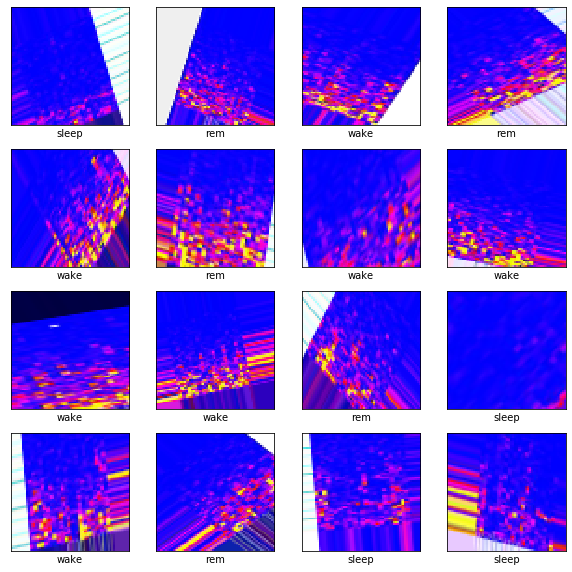

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
class_names = ['rem','sleep','wake']
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(sample_train_images[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[int(smaple_train_label[i])])
plt.show()      

In [0]:
model  = None
model = Sequential([
       Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape = (IMG_WIDTH,IMG_HEIGHT,3)),
       MaxPooling2D((2,2)),

       Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
       MaxPooling2D((2,2)),
       
       Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
       MaxPooling2D((2,2)),

       Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
       MaxPooling2D((2,2)),
       Flatten(),

       Dense(512,activation='relu'),
       Dense(3,activation='softmax')             
])

In [0]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
history = None
history = model.fit_generator(train_data,
                              steps_per_epoch=total_train // batch_size,
                              epochs=200,
                              validation_data=validation_data,
                              validation_steps=total_test // batch_size)

Epoch 1/200
16/16 [==============================] - 8s 514ms/step - loss: 1.0274 - acc: 0.5354 - val_loss: 0.7237 - val_acc: 0.7500
Epoch 2/200
16/16 [==============================] - 7s 433ms/step - loss: 0.8301 - acc: 0.6437 - val_loss: 0.7088 - val_acc: 0.6719
Epoch 3/200
16/16 [==============================] - 7s 434ms/step - loss: 0.7353 - acc: 0.6850 - val_loss: 0.8967 - val_acc: 0.6172
Epoch 4/200
16/16 [==============================] - 7s 439ms/step - loss: 0.6989 - acc: 0.6914 - val_loss: 1.4473 - val_acc: 0.3281
Epoch 5/200
16/16 [==============================] - 7s 436ms/step - loss: 0.7553 - acc: 0.6969 - val_loss: 0.6021 - val_acc: 0.7734
Epoch 6/200
16/16 [==============================] - 7s 429ms/step - loss: 0.6661 - acc: 0.7321 - val_loss: 1.0284 - val_acc: 0.5938
Epoch 7/200
16/16 [==============================] - 7s 421ms/step - loss: 0.6801 - acc: 0.7283 - val_loss: 0.9157 - val_acc: 0.5781
Epoch 8/200
16/16 [==============================] - 7s 435ms/step - 

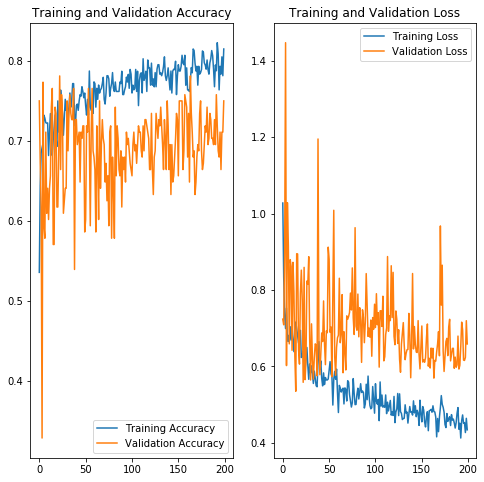

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(200)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
model.save('sleep_model_81.h5')

In [0]:
files.download('sleep_model_81.h5')